In [38]:
import os
from dotenv import load_dotenv
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import weaviate
import weaviate.classes as wvc

In [14]:
load_dotenv()

True

## First of all fetch the metadata about my book collection (approx 2200 books) including title, authors, description, tags and publisher

Load the source data about books, contained in a CSV file, into a list of python dictionaries, with some cleaning of the comments field

In [15]:
csv_file_path = os.getenv("CSVFILE")
columns_to_read = ['authors', 'comments', 'publisher', 'tags', 'title'] 
# Read only the specified columns from the CSV file
df = pd.read_csv(csv_file_path, usecols=columns_to_read)
# Clean the 'comments' column
# Remove '\n' characters
df['comments'] = df['comments'].str.replace('\n', ' ', regex=False)
# Convert the DataFrame into a list of dictionaries
books_dict = df.to_dict(orient='records')

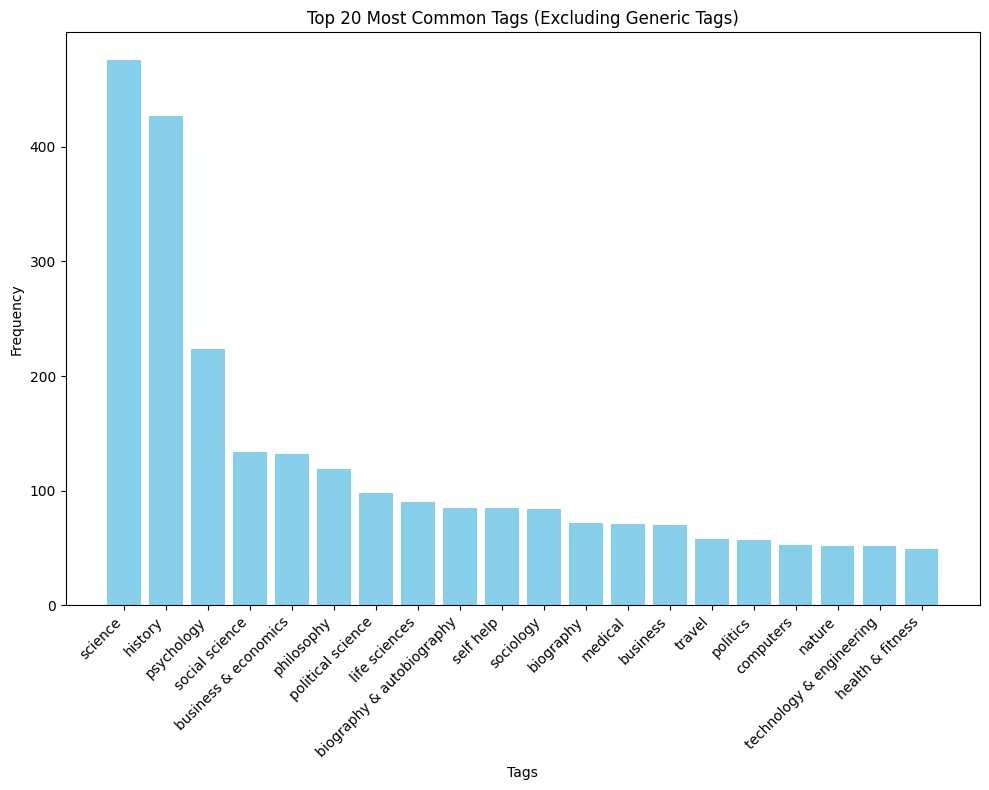

In [39]:
# List of generic tags to be excluded
generic_tags_list = ['general', 'non-fiction', 'reference', 'fiction']

all_tags = []
for item in df['tags']:
    if pd.notna(item) and isinstance(item, str):
        tags = [tag.strip().lower() for tag in item.split(',') if tag.strip().lower() not in generic_tags_list]
        all_tags.extend(tags)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Get the 20 most common tags along with their frequencies
most_common_tags = tag_counts.most_common(20)

# Extract tags and their counts for plotting
tags, counts = zip(*most_common_tags)

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.bar(tags, counts, color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Tags (Excluding Generic Tags)')
plt.xticks(rotation=45, ha='right')  # Rotate the tags for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()

## Now that the data has been fetched and quickly analyzed, let's proceed with the Weaviate vector database use

Create the Weaviate client (v4) with the OpenAI API key, connect and reply timeouts

In [16]:
# connect to client V4
wport = os.getenv("WPORT")
grpcport = os.getenv("GRPCPORT")
wclient = weaviate.connect_to_local(
    port=int(wport), grpc_port=int(grpcport), headers={"X-OpenAI-Api-Key": os.environ["OPENAI_APIKEY"]}, timeout=(2, 5)
)

Define the MyBook schema and create the corresponding collection and insert the data objects (approx. 30 seconds)

In [17]:
collname = os.getenv("COLLNAME")
if not wclient.collections.exists(collname): # if the schema/collection is missing create it
    books = wclient.collections.create(
        name=collname,
        vectorizer_config=wvc.Configure.Vectorizer.text2vec_openai(),
        generative_config=wvc.Configure.Generative.openai(), 
        properties=[
            wvc.Property(
                name="authors",
                data_type=wvc.DataType.TEXT
            ),
            wvc.Property(
                name="comments",
                data_type=wvc.DataType.TEXT
            ),
            wvc.Property(
                name="publisher",
                data_type=wvc.DataType.TEXT
            ),
            wvc.Property(
                name="tags",
                data_type=wvc.DataType.TEXT
            ),
            wvc.Property(
                name="title",
                data_type=wvc.DataType.TEXT
            ),
        ]
    )
    uuids = books.data.insert_many(books_dict)  # and add the book objects
else:
    books = wclient.collections.get(collname) # if the collection already existed just refer to it

# Now do some searches

In [18]:
limit = int(os.getenv("K_VECTORS"))

### First a semantic search

In [19]:
TOPIC = "exploration and traveling"
response = books.query.near_text(
    query=TOPIC,
    limit=limit
)

# Loop through each object in the 'objects' list
for obj in response.objects:
    print('*' * 50)
    for key, value in obj.properties.items():
        print(f'{key}: {value}')
    print('*' * 50)

**************************************************
title: The Age of Exploration: From Christopher Columbus to Ferdinand Magellan
tags: Juvenile Nonfiction, Reference, General, Adventure & Adventurers, history, Exploration & Discovery
publisher: Britanncia Educational Publishing
authors: Britannica Educational Publishing
comments: The Age of Exploration, which spanned roughly from 1400 to 1550, was the first time in history that European powers—eyeing new trade routes to the East or seeking to establish empires—began actively looking far past their own borders to gain a better understanding of the world and its many resources. The individuals who set out on behalf of the countries they represented came from a variety of backgrounds, and included master navigators such as Christopher Columbus and Ferdinand Magellan—the latter of whom was the first to circle the globe—as well as the often ruthless conquistadors of the New World such as Francisco Pizarro and Hernan Cortes. The exciting an

### Semantic search with a Boolean filter. 
Using the equal filter on the tags property. Filter is case insensitive

In [20]:
FILTER = "crime"
response = books.query.near_text(
    query="biology",
    limit=limit,
    filters=wvc.Filter(path="tags").equal(FILTER)
)

for obj in response.objects:
    print('*' * 50)
    for key, value in obj.properties.items():
        print(f'{key}: {value}')
    print('*' * 50)

**************************************************
title: The Scientist and the Spy: A True Story of China, the FBI, and Industrial Espionage
tags: Business & Economics, True Crime, Espionage, Globalization, Political Science, Intelligence & Espionage
publisher: Penguin
authors: Mara Hvistendahl
comments: A riveting true story of industrial espionage in which a Chinese-born scientist is pursued by the U.S. government for trying to steal trade secrets, by a finalist for the Pulitzer Prize in nonfiction.   In September 2011, sheriff’s deputies in Iowa encountered three ethnic Chinese men near a field where a farmer was growing corn seed under contract with Monsanto. What began as a simple trespassing inquiry mushroomed into a two-year FBI operation in which investigators bugged the men’s rental cars, used a warrant intended for foreign terrorists and spies, and flew surveillance planes over corn country—all in the name of protecting trade secrets of corporate giants Monsanto and DuPont P

### Generative search (single prompt)

In [21]:
response = books.generate.near_text(
    query="The history of human evolution",
    limit=limit,
    single_prompt="Explain {title} in a short paragraph of maximum thirty words."
)

#print(response.objects[0].generated)  # Inspect the generated text
for o in response.objects:
    print(o.properties["title"])
    print("-"*30)
    print(o.generated)
    print("\n")

Sapiens: A Brief History of Humankind
------------------------------
"Sapiens" is a concise exploration of human history, from the emergence of Homo sapiens to the present, examining our species' impact on the world and the forces that shaped our societies.


The Invisible History of the Human Race: How DNA and History Shape Our Identities and Our Futures
------------------------------
The Invisible History of the Human Race explores how our DNA and historical events intertwine to shape our identities and influence our future.


The Evolution of Everything: How New Ideas Emerge
------------------------------
"The Evolution of Everything" explores how complex systems, from language to technology, evolve through the interactions of countless individuals, challenging the notion of top-down control and highlighting the power of spontaneous order.


A Troublesome Inheritance: Genes, Race and Human History
------------------------------
A Troublesome Inheritance explores the controversial to

### Grouped task search
Grouped task search returns one response that includes all of the query results. By default grouped task search uses all object properties in the prompt.
grouped_properties: define object properties to use in the prompt. This limits the information in the prompt and reduces prompt length.

In [22]:
task = "Please write a short summary of the main concepts found in all of these books in a simple language. If you feel safe write the summary in Italian. I need this badly for a promotion. Please try to be as helpful as possible."

response = books.generate.near_text(
    query="The universe and it's history",
    limit=limit,
    grouped_task=task,
    grouped_properties=["title", "comment"]
)

# print the generated response
print(response.generated)

"The Universe: A Biography" - Questo libro fornisce una biografia dettagliata dell'universo, esplorando la sua formazione, la sua evoluzione e le sue caratteristiche principali.

"The Earth: From Myths to Knowledge" - Questo libro traccia la storia della Terra, partendo dai miti e dalle credenze antiche fino ad arrivare alle conoscenze scientifiche attuali. Esplora anche i processi geologici, l'evoluzione della vita e l'impatto dell'umanità sull'ambiente.

"13.8: The Quest to Find the True Age of the Universe and the Theory of Everything" - Questo libro si concentra sulla ricerca per determinare l'età reale dell'universo e sulla teoria che possa spiegare tutto ciò che accade al suo interno. Esplora anche le scoperte scientifiche che hanno portato a una migliore comprensione dell'universo.

"Welcome to the Universe: An Astrophysical Tour" - Questo libro offre un tour affascinante dell'astrofisica, introducendo i lettori ai concetti fondamentali dell'universo, come le stelle, le galassie

In [25]:
task = "What are the 20 most frequent tags of this book collections?"

response = books.generate.near_text(
    query="What are the topics of this book?",
    limit=limit,
    grouped_task=task,
    grouped_properties=["title", "comment"]
)

# print the generated response
print(response.generated)

Based on the given book collections, the 20 most frequent tags could be:

1. Science
2. Art
3. Mystery
4. Wonders
5. Illustration
6. Ideas
7. Brain
8. Life
9. Human
10. Series
11. Knowledge
12. Understanding
13. Explanation
14. Curiosity
15. Exploration
16. Research
17. Facts
18. Discovery
19. Wonderment
20. Explanation
